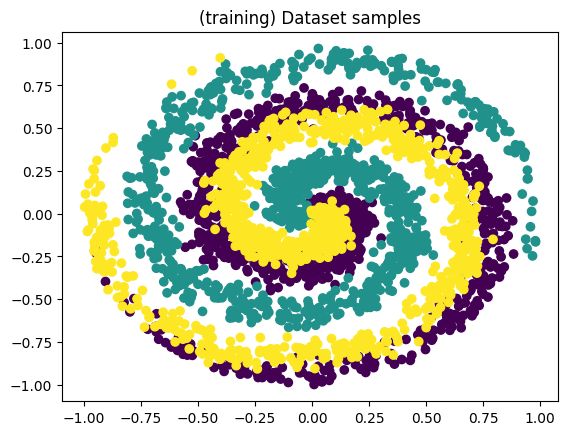

epoch: 0, acc: 0.381, loss: 1.099 (data_loss: 1.099, reg_loss: 0.000), lr: 0.02
epoch: 100, acc: 0.746, loss: 0.721 (data_loss: 0.663, reg_loss: 0.059), lr: 0.019999010049002574
epoch: 200, acc: 0.829, loss: 0.556 (data_loss: 0.466, reg_loss: 0.090), lr: 0.019998010197985302
epoch: 300, acc: 0.869, loss: 0.484 (data_loss: 0.385, reg_loss: 0.098), lr: 0.019997010446938183
epoch: 400, acc: 0.885, loss: 0.445 (data_loss: 0.345, reg_loss: 0.100), lr: 0.01999601079584623
epoch: 500, acc: 0.894, loss: 0.415 (data_loss: 0.317, reg_loss: 0.098), lr: 0.01999501124469445
epoch: 600, acc: 0.892, loss: 0.402 (data_loss: 0.307, reg_loss: 0.095), lr: 0.01999401179346786
epoch: 700, acc: 0.897, loss: 0.387 (data_loss: 0.297, reg_loss: 0.091), lr: 0.01999301244215147
epoch: 800, acc: 0.879, loss: 0.429 (data_loss: 0.332, reg_loss: 0.097), lr: 0.0199920131907303
epoch: 900, acc: 0.904, loss: 0.370 (data_loss: 0.276, reg_loss: 0.094), lr: 0.019991014039189386
epoch: 1000, acc: 0.905, loss: 0.362 (data_l

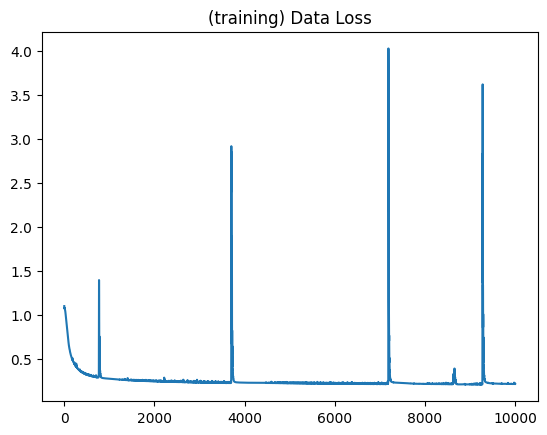

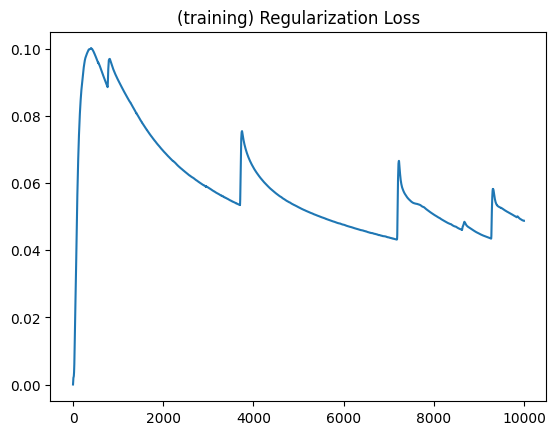

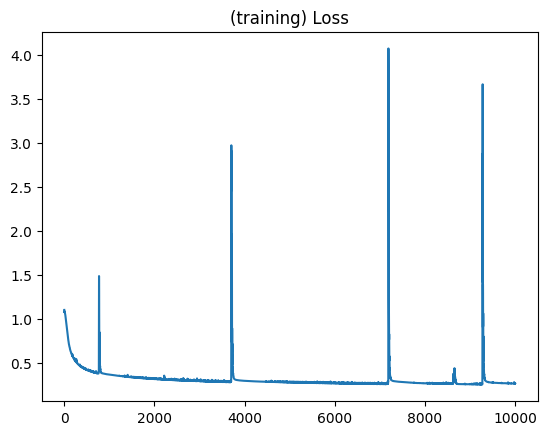

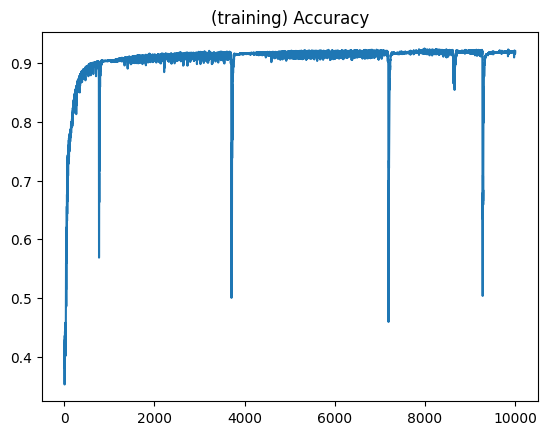

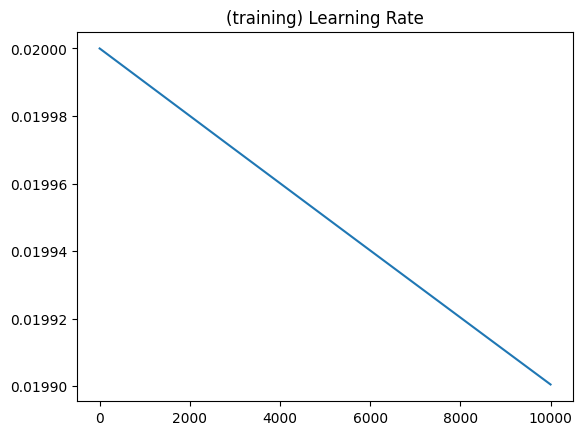

validation, acc: 0.913, loss: 0.279


In [14]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data
import matplotlib.pyplot as plt

nnfs.init()

class Layer_Dense:
    def __init__(self, n_inputs, n_neurons,
                 weight_regularizer_l1=0, weight_regularizer_l2=0,
                 bias_regularizer_l1=0, bias_regularizer_l2=0):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2
    
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
    
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
        
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights
        
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
            
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases
            
        self.dinputs = np.dot(dvalues, self.weights.T)
        
class Activation_ReLU():
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
        
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0
        
class Activation_Softmax:
    def forward(self, inputs):
        self.inputs = inputs
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities
        
    def backward(seld, dvalues):
        self.dinputs = np.empty_like(dvalues)
        
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(-1, 1)
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)
            
class Optimizer_SGD:
    def __init__(self, learning_rate=1, decay=0, momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.deacy * self.iterations))
            
    def update_params(self, layer):
        if self.momentum:
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
            
            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates
            
            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
        
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases
        
        layer.weights += weight_updates
        layer.biases += bias_updates
    
    def post_update_params(self):
        self.iterations += 1
        
class Optimizer_Adagrad:
    def __init__(self, learning_rate=1., decay=0., epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
    
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
            
    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_lise(layer.biases)
        
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2
        
        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
        
    def post_update_params(self):
        self.iterations += 1
        
class Optimizer_RMSprop:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
            
    def update_params(self, layer):
        if not(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
            
        layer.weight_cache = self.rho * layer.weight_cache + (1 - self.rho) * layer.dweights**2
        layer.bias_cache = self.rho * layer.bias_cache + (1 - self.rho) * layer.dbiases**2
        
        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
        
    def post_update_params(self):
        self.iterations += 1
        
class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
            
    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)
            
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases
        
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2
        
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_correted = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))
        
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_correted) + self.epsilon)
        
    def post_update_params(self):
        self.iterations += 1
        
class Loss:
    def regularization_loss(self, layer):
        regularization_loss = 0
        
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
            
        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)
            
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
            
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)
        
        return regularization_loss

    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        
        data_loss = np.mean(sample_losses)
        
        return data_loss
    
class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
            
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
        
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        
        labels = len(dvalues[0])
        
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
            
        self.dinputs = -y_true / dvalues
        self.dinputs = self.inputs / samples
    
class Activation_Softmax_Loss_CategoricalCrossentropy():
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()
        
    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.calculate(self.output, y_true)
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs = self.dinputs / samples
        
X, y = spiral_data(samples=1000, classes=3)
plt.scatter(X[:,0], X[:,1], c=y)
plt.title('(training) Dataset samples')
plt.show()

dense1 = Layer_Dense(2, 512, weight_regularizer_l2=5e-4, bias_regularizer_l2=5e-4)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(512, 3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
optimizer = Optimizer_Adam(learning_rate=0.02, decay=5e-7)

data_losses = []
regularization_losses = []
losses = []
accuracies = []
learning_rates = []

for epoch in range(10001):
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    
    data_loss = loss_activation.forward(dense2.output, y)
    data_losses.append(data_loss)
    regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2)
    regularization_losses.append(regularization_loss)
    loss = data_loss + regularization_loss
    losses.append(loss)
    
    predictions = np.argmax(loss_activation.output, axis=1)
    
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)
    accuracies.append(accuracy)
    
    learning_rates.append(optimizer.current_learning_rate)
    if not epoch%100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f} (' +
              f'data_loss: {data_loss:.3f}, ' +
              f'reg_loss: {regularization_loss:.3f}), ' +
              f'lr: {optimizer.current_learning_rate}')
    
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    
plt.plot(range(10001), data_losses)
plt.title('(training) Data Loss')
plt.show()
plt.plot(range(10001), regularization_losses)
plt.title('(training) Regularization Loss')
plt.show()
plt.plot(range(10001), losses)
plt.title('(training) Loss')
plt.show()
plt.plot(range(10001), accuracies)
plt.title('(training) Accuracy')
plt.show()
plt.plot(range(10001), learning_rates)
plt.title('(training) Learning Rate')
plt.show()

X_test, y_test = spiral_data(samples=100, classes=3)

dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
loss = loss_activation.forward(dense2.output, y_test)

predictions = np.argmax(loss_activation.output, axis=1)

if len(y_test.shape) == 2:
    y_test = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions==y_test)

print(f'validation, acc: {accuracy:.3f}, loss: {loss:.3f}')